In [2]:
from pathlib import Path
import torch
import pandas as pd
import yaml

In [102]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

folder = Path(config['summary']).parent
profiles = pd.read_csv(folder/'all profiles.csv')

In [165]:
from torch import nn
import numpy as np

x = torch.tensor(np.array(profiles[profiles['Parasite']==27]['Time [min]']))
y = torch.tensor(np.array(profiles[profiles['Parasite']==27]['Mean intensity']))
#y = torch.tensor(profiles[profiles['Parasite']==1]['Fraction'])

def gaussian(s,n):
    x = torch.arange(n, dtype=torch.double)    
    f = torch.exp(-0.5 * torch.square(x - n/2)/s)
    return f.reshape([1,1,n])  / f.sum()

def conv(f,h):
    n = f.shape[-1]
    m = h.shape[-1]        
    fp = torch.nn.functional.pad(f.reshape((1,n)),(1,m-2), 'replicate')    
    z = nn.functional.conv1d(fp, h)
    return z.squeeze()    


95.2984065150533 tensor([1.1847e+02, 1.3724e+03, 5.3647e+01, 7.5732e+00, 4.2060e-02, 4.7494e+01],
       dtype=torch.float64, requires_grad=True)


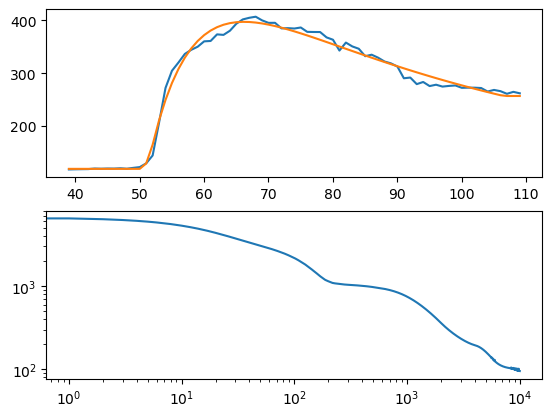

In [168]:
def func(x,weights):    
    a,b,c,d,e,f = weights    
    y = a + b * torch.clip(1-torch.exp(-(x-c)/d), 0) * torch.exp(-x/f)       
    h = gaussian(e, 7)
    return conv(y, h)  


weights = torch.tensor([y.min(),y.max()-y.min(),41.,5,1,200],requires_grad=True)
optimizer = torch.optim.Adam([weights], lr=0.01,weight_decay=0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,500,1000], gamma=0.8)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,0.1,max_lr=0.5,cycle_momentum=False)
h=[]
for iter in range(10000):
    optimizer.zero_grad()
    loss = torch.square(func(x,weights) - y).mean()
    loss.backward()
    optimizer.step()
    scheduler.step()
    h.append(loss.item())

print(loss.item(), weights)
import matplotlib.pyplot as plt
plt.subplot(211)
plt.plot(x.numpy(), y)
plt.plot(x.numpy(),func(x,weights).detach().numpy())
plt.subplot(212)
plt.loglog(h)
#plt.plot(x.numpy(),func(x,[110.,30.,63.,5,2,100]).detach().numpy())

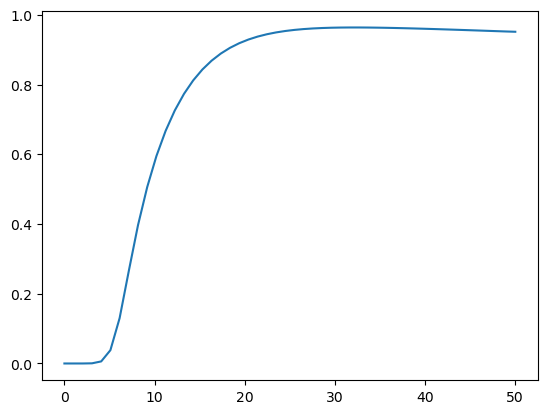

In [282]:
from scipy.signal import convolve
from scipy.optimize import curve_fit


def gaussian(x,s):    
    c = 0.5 * (x.max() + x.min())
    f = np.exp(-0.5 * np.square((x - c) / s))
    return f / f.sum()

def conv(f,h):
    m = h.shape[-1]    
    fp = np.pad(f, m, 'edge')
    z = convolve(fp, h,'same')
    return z[m:2*m]

def model_convexp(x,a,b,c,d,e,f):
    """Exponential x Error function model"""
    #return a + b * (0.5+0.5*erf((x - c) / e)) * ( 1 - np.exp(-(x - c) / d))
    y = a + b * np.maximum(0, 1 - np.exp(-(x - c) / d)) * np.exp(-x/f)
    h = gaussian(x, e)
    z = conv(y,h)    
    return z
x = np.linspace(0,50)
y = model_convexp(x,0,1,5,5,1,1000)
plt.plot(x,y)


array([120.80126581,  48.93323119,  36.02414718,   0.2409779 ,
         0.46647963, 151.54006318])

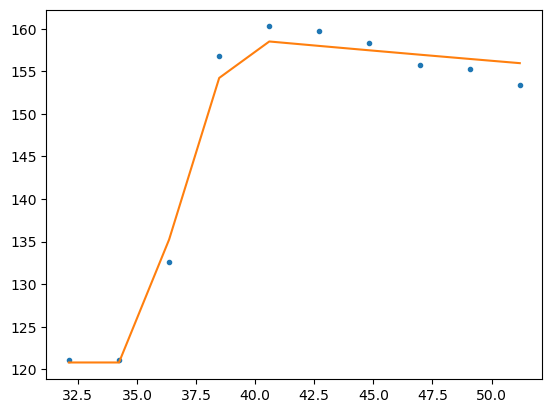

In [286]:


def initialize_parameters(x,y):
    ym = y#medfilt(y, 3)
    a, b = ym.min(), ym.max()
    alpha = 0.2
    y0, y1 = a + alpha * (b - a), a + (1-alpha) * (b - a)
    x0, x1 = 0.0, 0.0 
    for i, yi in enumerate(ym):  
        if yi > y0 and x0 == 0:
            x0 = x[i-1] + (y0-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
        if yi > y1 and x1 == 0:
            x1 = x[i-1] + (y1-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
    p = [a, b - a, x0, (x1 - x0) / 3, 1, 1000]
    l = [0.9 * a - 0.1 * b, 0.75*(b-a), x0 - 1, 0.1*(x1-x0),0.1,0]
    u = [0.9 * a + 0.1 * b, 1.25*(b-a), x0 + 1, 10*(x1-x0),10,1e6]        
    return {'p0':p, 'bounds':(l,u)}

x = np.array(profiles[profiles['Parasite']==3]['Time [min]'])
y = np.array(profiles[profiles['Parasite']==3]['Mean intensity'])

#p,c = curve_fit(model_convexp, x, y, [y.min(),y.max()-y.min(),42.,2,1,1000])
init = initialize_parameters(x, y)
p,c = curve_fit(model_convexp, x, y, **init)
plt.plot(x,y,'.')
plt.plot(x,model_convexp(x,*p))
#plt.plot(np.linspace(38,55),model_convexp(np.linspace(38,55),*p))
p


In [226]:
def initialize_parameters(x,y):
    ym = y#medfilt(y,3)
    a, b = ym.min(), ym.max()
    alpha = 0.2
    y0, y1 = a + alpha * (b - a), a + (1-alpha) * (b - a)
    x0, x1 = 0.0, 0.0 
    for i, yi in enumerate(ym):  
        if yi > y0 and x0 == 0:
            x0 = x[i-1] + (y0-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
        if yi > y1 and x1 == 0:
            x1 = x[i-1] + (y1-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
    p = [a, b - a, x0, (x1 - x0) / 3, 1, 1000]
    l = [0.9 * a - 0.1 * b, 0.75*(b-a), x0 - 1, 0.1*(x1-x0),0.1,0]
    u = [0.9 * a + 0.1 * b, 1.25*(b-a), x0 + 1, 10*(x1-x0),10,1e6]    
    return {'p0':p, 'bounds':(l,u)}
initialize_parameters(x,y)

{'p0': [119.71547904,
  37.665179022000004,
  41.59049110712956,
  1.0227603575679751,
  1,
  1000],
 'bounds': ([92.0058653298,
   28.248884266500003,
   40.59049110712956,
   0.30682810727039256,
   0.1,
   0],
  [123.4819969422,
   47.08147377750001,
   42.59049110712956,
   30.682810727039254,
   10,
   1000000.0])}